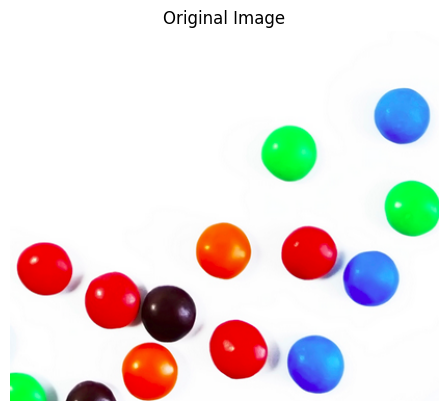

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("image.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
plt.show()

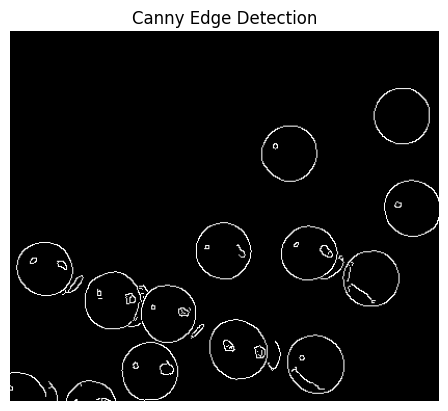

In [27]:
edges = cv2.Canny(gray, 50, 150)

image_ln = cv2.imread("pic.png")
gray_ln = cv2.cvtColor(image_ln, cv2.COLOR_BGR2GRAY)
edges_ln = cv2.Canny(gray_ln, 50, 150)

plt.imshow(edges, cmap="gray")
plt.title("Canny Edge Detection")
plt.axis("off")
plt.show()


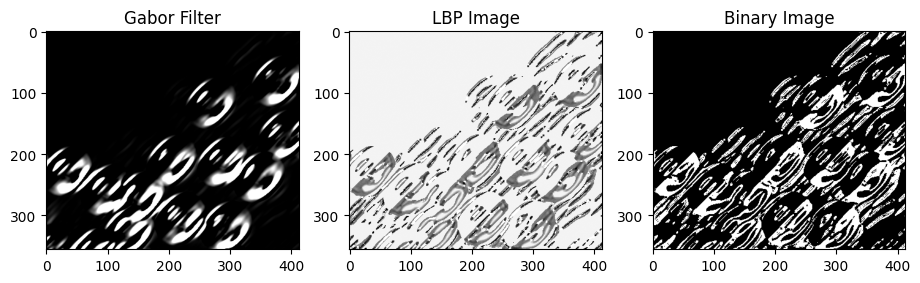

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern


image = cv2.imread("image.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gabor filter
def apply_gabor_filter(img, ksize=31, sigma=4, theta=np.pi/4, lambd=10, gamma=0.5):
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, ktype=cv2.CV_32F)
    return cv2.filter2D(img, cv2.CV_8UC3, kernel)

gabor_filtered = apply_gabor_filter(gray)

# Apply Local Binary Pattern (LBP)
radius = 3
n_points = 8 * radius  
lbp = local_binary_pattern(gabor_filtered, n_points, radius, method="uniform")


lbp = np.uint8((lbp / lbp.max()) * 255)


ret, thresh = cv2.threshold(lbp, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


kernel = np.ones((3, 3), np.uint8)
sure_bg = cv2.dilate(thresh, kernel, iterations=3)


dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)


sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)


ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1  
markers[unknown == 255] = 0  


# Show results
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1), plt.imshow(gabor_filtered, cmap='gray'), plt.title("Gabor Filter")
plt.subplot(1, 4, 2), plt.imshow(lbp, cmap='gray'), plt.title("LBP Image")
plt.subplot(1, 4, 3), plt.imshow(thresh, cmap='gray'), plt.title("Binary Image")
plt.show()


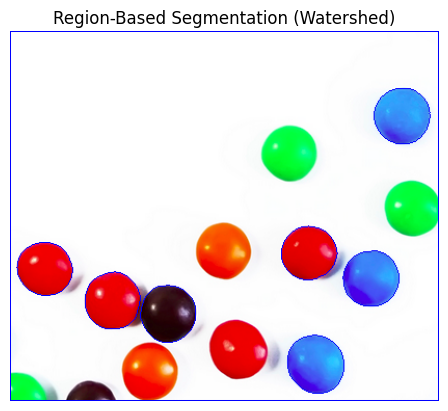

In [29]:
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((3, 3), np.uint8)
sure_bg = cv2.dilate(thresh, kernel, iterations=3)
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

image_copy = image.copy()
cv2.watershed(image_copy, markers)
image_copy[markers == -1] = [255, 0, 0] 

plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.title("Region-Based Segmentation (Watershed)")
plt.axis("off")
plt.show()

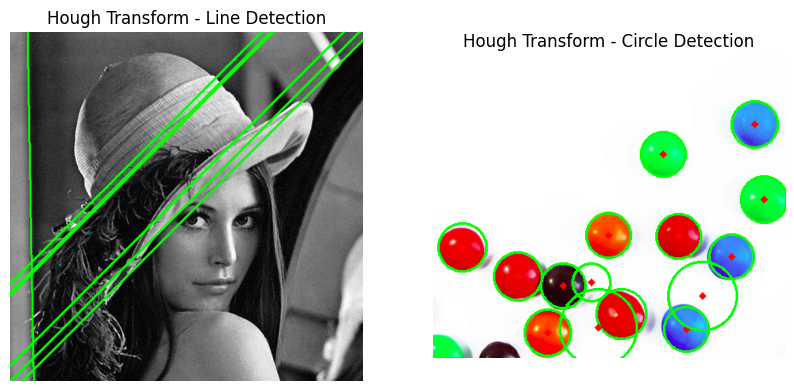

In [30]:
lines = cv2.HoughLines(edges_ln, 1, np.pi / 180, 200)
image_lines = image_ln.copy()
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, param1=50, param2=30, minRadius=10, maxRadius=100)
image_circles = image.copy()

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(image_circles, (i[0], i[1]), i[2], (0, 255, 0), 2)
        cv2.circle(image_circles, (i[0], i[1]), 2, (0, 0, 255), 3)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_lines, cv2.COLOR_BGR2RGB))
plt.title("Hough Transform - Line Detection")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_circles, cv2.COLOR_BGR2RGB))
plt.title("Hough Transform - Circle Detection")
plt.axis("off")

plt.show()

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import fashion_mnist, cifar100
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

test_image = np.expand_dims(x_test[0], axis=0)
test_image = np.expand_dims(test_image, axis=-1)
prediction = model.predict(test_image)
predicted_label = np.argmax(prediction)

print(f"Predicted Label: {predicted_label}")

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7988 - loss: 0.5749 - val_accuracy: 0.8803 - val_loss: 0.3344
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8970 - loss: 0.2852 - val_accuracy: 0.8982 - val_loss: 0.2902
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9131 - loss: 0.2411 - val_accuracy: 0.9054 - val_loss: 0.2670
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9228 - loss: 0.2111 - val_accuracy: 0.9059 - val_loss: 0.2607
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9338 - loss: 0.1821 - val_accuracy: 0.9075 - val_loss: 0.2663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Label: 9



0: 640x640 1 person, 1 umbrella, 78.9ms
Speed: 5.5ms preprocess, 78.9ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 640)


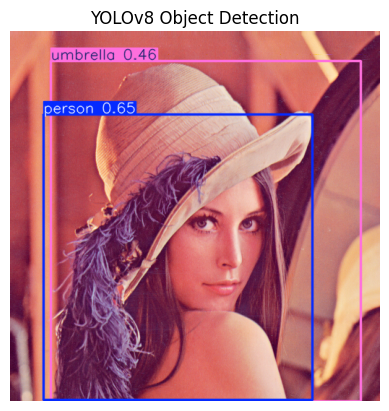

In [32]:
# from ultralytics import YOLO
import ultralytics
import cv2
import matplotlib.pyplot as plt

model = ultralytics.YOLO("yolov8n.pt")  

image_path = "Lena_Image.png"  
image = cv2.imread(image_path)

results = model(image)

for r in results:
    image_with_boxes = r.plot()

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.title("YOLOv8 Object Detection")
plt.axis("off")
plt.show()

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


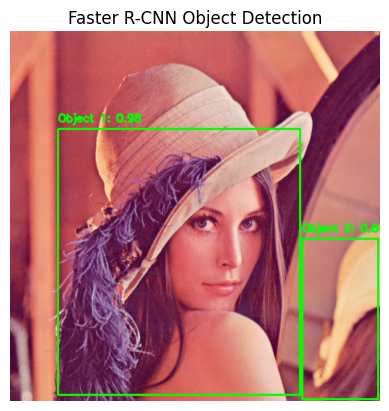

In [33]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

model_frcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_frcnn.eval()
image_path = "Lena_Image.png"
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)  

with torch.no_grad():
    predictions = model_frcnn(image_tensor)

image_cv = cv2.imread(image_path)
for i, box in enumerate(predictions[0]["boxes"]):
    score = predictions[0]["scores"][i].item()
    if score > 0.6:  
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"Object {i+1}: {score:.2f}"
        cv2.putText(image_cv, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
plt.title("Faster R-CNN Object Detection")
plt.axis("off")
plt.show()